In [203]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import scipy.stats as stat
from scipy.stats import zscore

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

---
## Staller 2022 5 Library TFs

In [77]:
AD_coA_finches = pd.read_csv("data/staller5libADs_coAs_finches.csv").drop("Unnamed: 0", axis=1)
AD_AD_finches = pd.read_csv("data/staller5libADs_self_finches.csv").drop("Unnamed: 0", axis=1)
AD_library = pd.read_csv("data/Staller2022_5AD_library.csv")
coAs = pd.read_csv("helperdata/soto_cofactors_regions.csv", index_col=0)

In [78]:
AD_coA_pivot = AD_coA_finches.pivot(index="Prot1", columns="Prot2", values="Total e (mf)")
AD_library = AD_library[[len(x) >= 20 for x in AD_library["ADseq"]]] #filter to remove AD seq < 20 aa
AD_library["Relative Activity"] = AD_library["Activity_Mean_MSS18"] - 2000

---
## AD:coA

In [386]:
AD_coA_finches_activity = AD_coA_finches.merge(AD_library[["Relative Activity"]], left_on = "Prot1", right_index = True)

In [392]:
%%script echo
#look at specific AD:coA attraction vs repulsion vs activity
MED_interaction = AD_coA_finches_activity[["KIX" in x and "Interaction" in x for x in AD_coA_finches_activity["Prot2"]]]
print(len(MED_interaction["Prot2"].unique()))

for domain in MED_interaction["Prot2"].unique():
    domain_only = MED_interaction[MED_interaction["Prot2"] == domain]
    sns.scatterplot(domain_only, x = "Attractive e (mf)", y = "Repulsive e (mf)", hue = "Relative Activity", alpha=0.5, palette="coolwarm")
    plt.title("Cofactor Domain Annotation: " + domain.replace("_", " "))
    plt.xlabel("FINCHES Attractive Epsilon")
    plt.ylabel("FINCHES Repulsive Epsilon")
    plt.savefig("figures/staller5lib/Mediator/{}.png".format(domain.replace(" ", "_")), bbox_inches="tight")
    plt.show()
    plt.clf()

In [304]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [315]:
X = AD_coA_pivot[[x for x in AD_coA_pivot.columns.to_list() if "residues" not in x]]
y = AD_library["Relative Activity"]
kbestfeatures = SelectKBest(f_regression, k=2)

bestfeatures = kbestfeatures.fit_transform(X, y)
bestfeatures_labels = kbestfeatures.get_feature_names_out()

X_new_df = pd.DataFrame(bestfeatures)
X_new_df.columns = bestfeatures_labels
X_new_df["Activity"] = y

In [307]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [321]:
X = AD_coA_pivot[[x for x in AD_coA_pivot.columns.to_list() if "residues" not in x]]
y = AD_library["Relative Activity"]

max_score = 0
best_k = 0
best_results = pd.DataFrame()

for k in range(2, 102, 2):
    kbestfeatures = SelectKBest(f_regression, k=k)
    bestfeatures = kbestfeatures.fit_transform(X, y)
    bestfeatures_labels = kbestfeatures.get_feature_names_out()

    X_new_df = pd.DataFrame(bestfeatures)
    X_new_df.columns = bestfeatures_labels

    randomforest = RandomForestRegressor(random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_new_df, y, test_size=0.2, random_state=42)
    randomforest.fit(X_train, y_train)

    score = randomforest.score(X_test, y_test)

    if score > max_score:
        max_score = score
        best_k = k
        best_results = pd.DataFrame({"Predicted Activity": randomforest.predict(X_test), "Actual Activity": y_test})


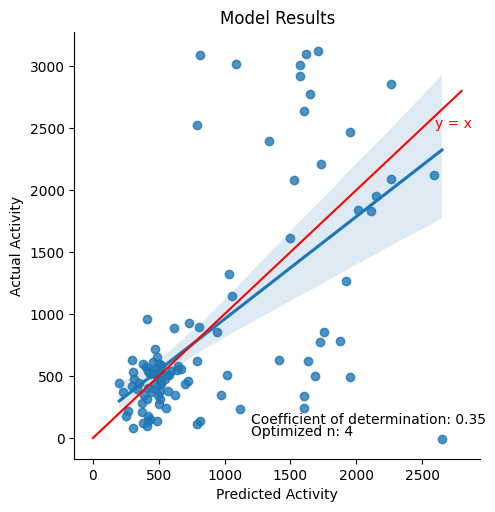

In [ ]:
sns.lmplot(best_results, x = "Predicted Activity", y = "Actual Activity")
sns.lineplot(x = range(2800), y = range(2800), color="red")
plt.text(2600, 2500, "y = x", color="red")
plt.text(1200, 120, "Coefficient of determination: " + str(np.round(max_score, 2)))
plt.text(1200, 20, "Optimized n: " + str(best_k))
plt.title("Model Results for ")
plt.savefig("figures/staller5lib/regressionmodel_results.png", bbox_inches="tight")

In [330]:
kbestfeatures = SelectKBest(f_regression, k=best_k)
bestfeatures = kbestfeatures.fit_transform(X, y)
bestfeatures_labels = kbestfeatures.get_feature_names_out()

best_model_df = pd.DataFrame(bestfeatures)
best_model_df.columns = bestfeatures_labels
best_model_df["Activity"] = y

In [342]:
from localcider.sequenceParameters import SequenceParameters

In [431]:
important = coAs[[x in bestfeatures_labels for x in coAs["Region ID"]]][["Region ID", "Region sequence", "Region sequence length"]]

tfDBD = "SRPGERPFQCRICMRNFSEEANLRRHTRTHTGEKPFQCRICMRNFSDHSSLKRHLRTHTGSQKPFQCRICMRNFSQSANLLRHTRTHTGEKPFQCRICMRNFSDPSSLKRHLRTHTGSQKPFQCRICMRNFSQQTNLTRHTRTHTGEKPFQCRICMRNFSDATQLVRHLRTHLR"
important = pd.DataFrame({"Region sequence": [tfDBD]})

important["Mean net charge"] = important["Region sequence"].apply(lambda x: SequenceParameters(x).get_mean_net_charge(pH=7))
important["Fraction positive"] = important["Region sequence"].apply(lambda x: SequenceParameters(x).get_fraction_positive())
important["Fraction negative"] = important["Region sequence"].apply(lambda x: SequenceParameters(x).get_fraction_negative())
important["Kyte-Doolittle hydrophobicity"] = important["Region sequence"].apply(lambda x: SequenceParameters(x).get_mean_hydropathy())
important["Fraction of expanding residues"] = important["Region sequence"].apply(lambda x: SequenceParameters(x).get_fraction_expanding())
important["Fraction of disorder-promoting residues"] = important["Region sequence"].apply(lambda x: SequenceParameters(x).get_fraction_disorder_promoting())

important

,Region sequence,Mean net charge,Fraction positive,Fraction negative,Kyte-Doolittle hydrophobicity,Fraction of expanding residues,Fraction of disorder-promoting residues
0,SRPGERPFQCRICMRNFSEEANLRRHTRTHTGEKPFQCRICMRNFS...,0.165278,0.201149,0.051724,3.437931,0.298851,0.672414


<Axes: xlabel='AES_Disordered_1', ylabel='CCAR1_Disordered_5'>

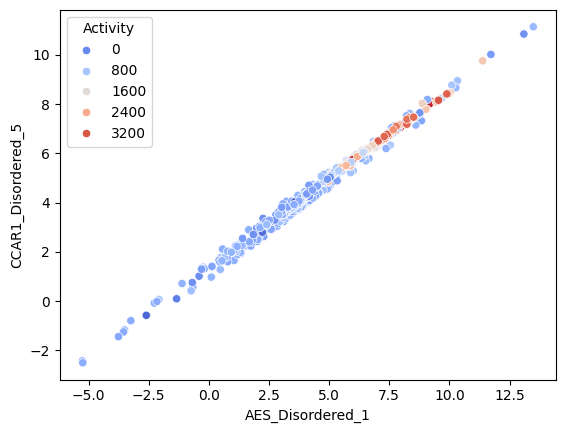

In [354]:
sns.scatterplot(best_model_df, x = "AES_Disordered_1", y = "CCAR1_Disordered_5", hue = "Activity", palette="coolwarm")

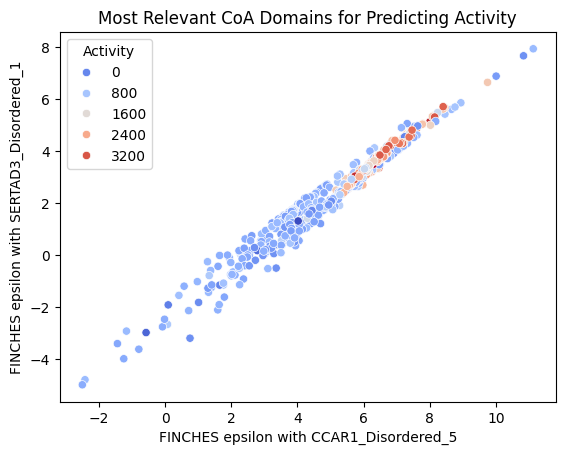

In [316]:
sns.scatterplot(data = X_new_df, x = X_new_df.columns[0], y = X_new_df.columns[1], hue = "Activity", palette="coolwarm")
plt.xlabel("FINCHES epsilon with " + X_new_df.columns[0])
plt.ylabel("FINCHES epsilon with " + X_new_df.columns[1])
plt.title("Most Relevant CoA Domains for Predicting Activity")
plt.savefig("figures/staller5lib/scatterplot_feature_selection.png")

#### Model using Attractive Epsilon only

Text(0.5, 1.0, 'Most Relevant CoA Domains for Predicting Activity')

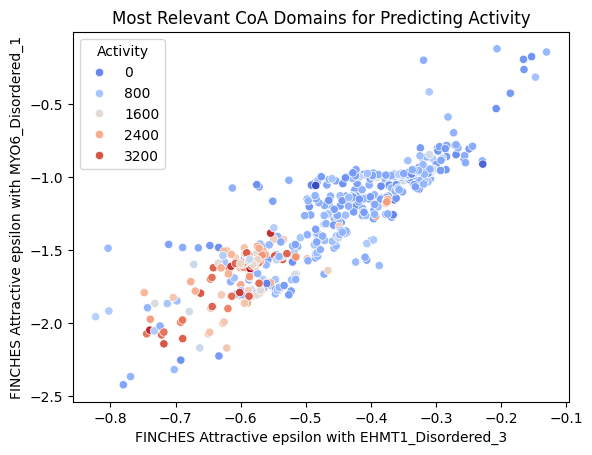

In [435]:
AD_coA_pivot_attractive = AD_coA_finches.fillna(0).pivot(index="Prot1", columns="Prot2", values="Attractive e (mf)")
X = AD_coA_pivot_attractive[[x for x in AD_coA_pivot_attractive.columns.to_list() if "residues" not in x]]
y = AD_library["Relative Activity"]
kbestfeatures_attractive = SelectKBest(f_regression, k=2)

bestfeatures_attractive = kbestfeatures_attractive.fit_transform(X, y)
bestfeatures_labels_attractive = kbestfeatures_attractive.get_feature_names_out()

X_new_df = pd.DataFrame(bestfeatures_attractive)
X_new_df.columns = bestfeatures_labels_attractive
X_new_df["Activity"] = y
sns.scatterplot(data = X_new_df, x = X_new_df.columns[0], y = X_new_df.columns[1], hue = "Activity", palette="coolwarm")
plt.xlabel("FINCHES Attractive epsilon with " + X_new_df.columns[0])
plt.ylabel("FINCHES Attractive epsilon with " + X_new_df.columns[1])
plt.title("Most Relevant CoA Domains for Predicting Activity")
#plt.savefig("figures/staller5lib/scatterplot_feature_selection.png")

In [436]:
X = AD_coA_pivot_attractive[[x for x in AD_coA_pivot_attractive.columns.to_list() if "residues" not in x]]
y = AD_library["Relative Activity"]

max_score = 0
best_k = 0
best_results = pd.DataFrame()

for k in range(2, 102, 2):
    kbestfeatures = SelectKBest(f_regression, k=k)
    bestfeatures = kbestfeatures.fit_transform(X, y)
    bestfeatures_labels = kbestfeatures.get_feature_names_out()

    X_new_df = pd.DataFrame(bestfeatures)
    X_new_df.columns = bestfeatures_labels

    randomforest = RandomForestRegressor(random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_new_df, y, test_size=0.2, random_state=42)
    randomforest.fit(X_train, y_train)

    score = randomforest.score(X_test, y_test)

    if score > max_score:
        max_score = score
        best_k = k
        best_results = pd.DataFrame({"Predicted Activity": randomforest.predict(X_test), "Actual Activity": y_test})


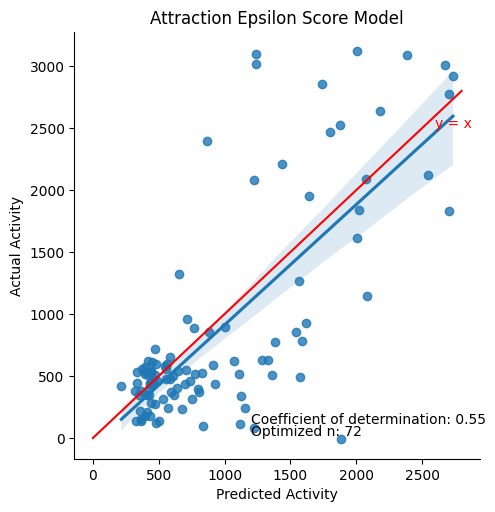

In [438]:
sns.lmplot(best_results, x = "Predicted Activity", y = "Actual Activity")
plt.text(2600, 2500, "y = x", color="red")
sns.lineplot(x = range(2800), y = range(2800), color="red")
plt.text(1200, 120, "Coefficient of determination: " + str(np.round(max_score, 2)))
plt.text(1200, 20, "Optimized n: " + str(best_k))
plt.title("Attraction Epsilon Score Model")
plt.savefig("figures/staller5lib/regressionmodel_attraction_only_results.png", bbox_inches="tight")

In [439]:
kbestfeatures = SelectKBest(f_regression, k=best_k)
bestfeatures = kbestfeatures.fit_transform(X, y)
bestfeatures_labels = kbestfeatures.get_feature_names_out()

best_model_df = pd.DataFrame(bestfeatures)
best_model_df.columns = bestfeatures_labels
best_model_df["Activity"] = y

In [441]:
[x for x in bestfeatures_labels if "Disordered" not in x]

['ACTN4_Interaction with VCL_2',
 'ALYREF_Sufficient for RNA-binding, interaction with NXF1-NXT1 heterodimer_1',
 'CHEK2_T-loop/activation segment_1',
 'MYO6_IQ_1',
 'NFKBIZ_OCA_1',
 'NPAT_Required for acceleration of G1 phase_5',
 'OGT_Required for phosphatidylinositol 3,4,5-triphosphate binding_1',
 'POU2AF1_OCA_1',
 'RBBP8_Essential for binding to the MRN complex and for RPA focus formation on DNA damage_1',
 'SETD1A_Interaction with WDR82_1',
 'TCP10L_Leucine-zipper_1',
 'TNNI2_Involved in binding TNC and actin_1',
 'WWC1_Interaction with PRKCZ_2']

---
## AD-AD

In [22]:
AD_AD_finches["Activity"] = AD_library["Relative Activity"]
AD_AD_finches = AD_AD_finches.fillna(0)

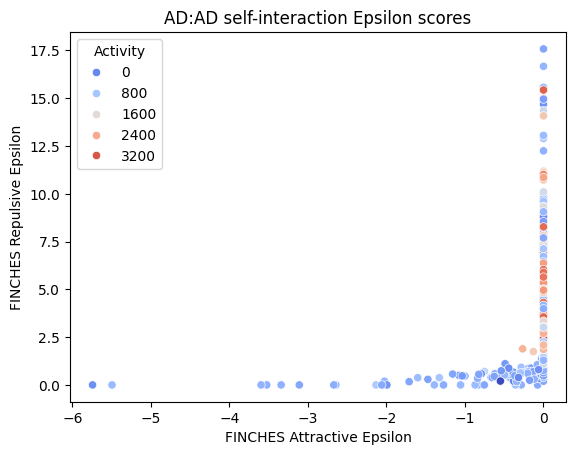

In [44]:
#Self-interaction of ADs
sns.scatterplot(AD_AD_finches, x = "Attractive e (mf)", y = "Repulsive e (mf)", hue="Activity", palette="coolwarm")
plt.title("AD:AD self-interaction Epsilon scores")
plt.xlabel("FINCHES Attractive Epsilon")
plt.ylabel("FINCHES Repulsive Epsilon")
plt.savefig("figures/staller5lib/scatterplot_attractive_repulsive_activity.png", bbox_inches="tight")

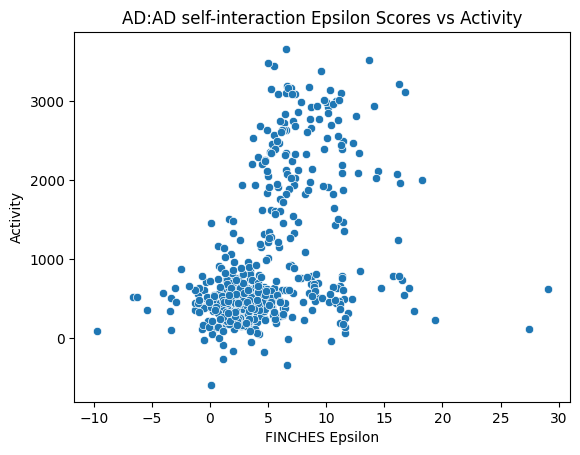

In [43]:
#Self-interaction of ADs
sns.scatterplot(AD_AD_finches, x = "Total e (mf)", y = "Activity")
plt.title("AD:AD self-interaction Epsilon Scores vs Activity")
plt.xlabel("FINCHES Epsilon")
plt.savefig("figures/staller5lib/scatter_activity_vs_epsilon.png", bbox_inches="tight")

In [5]:
AD_AD_finches.head()

,Attractive e (mf),Repulsive e (mf),Total e (mf)
0,-0.142922,0.605947,0.491009
1,NaN,2.817432,4.445800
2,NaN,15.573020,29.069860
3,NaN,8.981997,16.510717
4,NaN,7.559547,14.144796


---
## AD:coA combined

In [381]:
AD_AD_finches_epsilon = AD_AD_finches.rename({"Total e (mf)": "AD:AD Epsilon"}, axis=1)[["AD:AD Epsilon"]]
AD_coA_AD_merged = AD_coA_finches.merge(AD_AD_finches_epsilon, left_on="Prot1", right_index=True)
AD_coA_AD_merged["AD:coA - AD:AD"] = AD_coA_AD_merged["Total e (mf)"] - AD_coA_AD_merged["AD:AD Epsilon"]
AD_coA_AD_merged = AD_coA_AD_merged.merge(AD_library[["Relative Activity"]], left_on="Prot1", right_index=True)
AD_coA_AD_merged.head()

,Prot1,Prot2,Attractive e (mf),Repulsive e (mf),Total e (mf),AD:AD Epsilon,AD:coA - AD:AD,Relative Activity
0,0.0,MED19_Disordered_1,NaN,1.632426,2.518036,0.491009,2.027027,123.98545
525,0.0,MED19_Disordered_2,NaN,2.045244,2.937747,0.491009,2.446738,123.98545
1050,0.0,CNOT1_Disordered_1,NaN,1.156325,2.143715,0.491009,1.652706,123.98545
1575,0.0,CNOT1_Interaction with ZFP36_1,-0.844370,0.522932,-0.142021,0.491009,-0.633030,123.98545
2100,0.0,"CNOT1_Interaction with CNOT6, CNOT6L, CNOT7 an...",-0.336573,0.905085,1.028247,0.491009,0.537238,123.98545


In [395]:
AD_coA_AD_pivot = AD_coA_AD_merged.pivot(index="Prot1", columns="Prot2", values="AD:coA - AD:AD")
AD_coA_AD_pivot.head()

Prot2,AATF_Acidic residues_1,AATF_Acidic residues_2,AATF_Disordered_1,AATF_Disordered_2,AATF_POLR2J binding_1,AATF_RB1 and SP1 binding_1,AATF_RB1 binding_1,ABL1_Basic and acidic residues_2,ABL1_Basic and acidic residues_5,ABL1_CAP_1,...,ZNF638_Polar residues_1,ZNF638_Polar residues_2,ZNF638_Polar residues_3,ZNF638_Polar residues_5,ZNF638_RRM 1_1,ZNF638_RRM 2_1,ZNF703_Disordered_1,ZNF703_Disordered_2,ZNF703_Disordered_3,ZNF703_Polar residues_2
Prot1,,,,,,,,,,,,,,,,,,,,,
0.0,2.244234,3.076619,1.753756,3.123112,0.426518,0.822017,0.068532,2.100608,0.731010,1.282732,...,3.762377,3.262475,3.280305,2.318098,1.043759,0.356880,1.823522,2.201908,3.143777,3.881274
1.0,6.959913,7.755044,2.356730,2.156016,-4.068161,-2.690483,-3.920135,-1.092106,-6.432925,-2.119141,...,-3.112376,2.685366,-1.264009,-3.969666,-2.177334,-3.118352,-2.418540,-2.168742,-1.766401,-0.258362
2.0,1.786388,2.872440,-11.653131,-15.431483,-30.222440,-26.214036,-28.045892,-23.599108,-37.381182,-25.768294,...,-33.863538,-14.212263,-27.528976,-33.405513,-25.590441,-27.223041,-27.820229,-27.568617,-28.421005,-25.011499
3.0,6.749294,7.580592,-3.276950,-5.658602,-16.890507,-13.953501,-15.538667,-11.861179,-22.285775,-13.449751,...,-19.040750,-4.728372,-14.221739,-19.095538,-13.249395,-14.601202,-14.900831,-14.751461,-15.214905,-12.528064
4.0,6.168944,7.206046,-2.468236,-4.727765,-15.068051,-12.313217,-13.386524,-10.241522,-18.914592,-12.030850,...,-16.470032,-4.164271,-12.734008,-16.344907,-12.037029,-13.326302,-13.271349,-12.854367,-13.422830,-10.667953


In [401]:
X = AD_coA_AD_pivot[[x for x in AD_coA_AD_pivot.columns.to_list() if "residues" not in x]]
y = AD_library["Relative Activity"]

max_score = 0
best_k = 0
best_results = pd.DataFrame()

for k in range(20, 1000, 20):
    kbestfeatures = SelectKBest(f_regression, k=k)
    bestfeatures = kbestfeatures.fit_transform(X, y)
    bestfeatures_labels = kbestfeatures.get_feature_names_out()

    X_new_df = pd.DataFrame(bestfeatures)
    X_new_df.columns = bestfeatures_labels

    randomforest = RandomForestRegressor(random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_new_df, y, test_size=0.2, random_state=42)
    randomforest.fit(X_train, y_train)

    score = randomforest.score(X_test, y_test)

    if score > max_score:
        max_score = score
        best_k = k
        best_results = pd.DataFrame({"Predicted Activity": randomforest.predict(X_test), "Actual Activity": y_test})

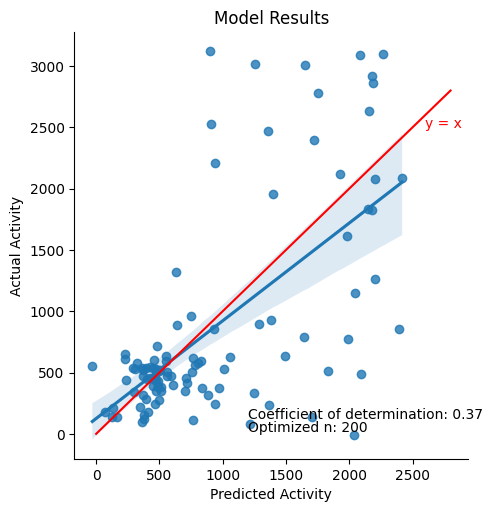

In [403]:
sns.lmplot(best_results, x = "Predicted Activity", y = "Actual Activity")
sns.lineplot(x = range(2800), y = range(2800), color="red")
plt.text(2600, 2500, "y = x", color="red")
plt.text(1200, 120, "Coefficient of determination: " + str(np.round(max_score, 2)))
plt.text(1200, 20, "Optimized n: " + str(best_k))
plt.title("Model Results")
plt.savefig("figures/staller5lib/regressionmodel_results_with_ADAD.png", bbox_inches="tight")

In [ ]:
kbestfeatures = SelectKBest(f_regression, k=best_k)
bestfeatures = kbestfeatures.fit_transform(X, y)
bestfeatures_labels = kbestfeatures.get_feature_names_out()

best_model_df = pd.DataFrame(bestfeatures)
best_model_df.columns = bestfeatures_labels
best_model_df["Activity"] = y

#### AD:coA attractive epsilon only

In [451]:
AD_AD_finches_epsilon = AD_AD_finches.rename({"Total e (mf)": "AD:AD Epsilon"}, axis=1)[["AD:AD Epsilon"]]
AD_coA_AD_merged = AD_coA_finches.merge(AD_AD_finches_epsilon, left_on="Prot1", right_index=True).fillna(0)
AD_coA_AD_merged["AD:coA - AD:AD"] = AD_coA_AD_merged["Attractive e (mf)"] - AD_coA_AD_merged["AD:AD Epsilon"]
AD_coA_AD_merged = AD_coA_AD_merged.merge(AD_library[["Relative Activity"]], left_on="Prot1", right_index=True)
AD_coA_AD_merged.head()

,Prot1,Prot2,Attractive e (mf),Repulsive e (mf),Total e (mf),AD:AD Epsilon,AD:coA - AD:AD,Relative Activity
0,0.0,MED19_Disordered_1,0.000000,1.632426,2.518036,0.491009,-0.491009,123.98545
525,0.0,MED19_Disordered_2,0.000000,2.045244,2.937747,0.491009,-0.491009,123.98545
1050,0.0,CNOT1_Disordered_1,0.000000,1.156325,2.143715,0.491009,-0.491009,123.98545
1575,0.0,CNOT1_Interaction with ZFP36_1,-0.844370,0.522932,-0.142021,0.491009,-1.335379,123.98545
2100,0.0,"CNOT1_Interaction with CNOT6, CNOT6L, CNOT7 an...",-0.336573,0.905085,1.028247,0.491009,-0.827582,123.98545


In [454]:
AD_coA_AD_pivot = AD_coA_AD_merged.pivot(index="Prot1", columns="Prot2", values="AD:coA - AD:AD")
AD_coA_AD_pivot.head()

Prot2,AATF_Acidic residues_1,AATF_Acidic residues_2,AATF_Disordered_1,AATF_Disordered_2,AATF_POLR2J binding_1,AATF_RB1 and SP1 binding_1,AATF_RB1 binding_1,ABL1_Basic and acidic residues_2,ABL1_Basic and acidic residues_5,ABL1_CAP_1,...,ZNF638_Polar residues_1,ZNF638_Polar residues_2,ZNF638_Polar residues_3,ZNF638_Polar residues_5,ZNF638_RRM 1_1,ZNF638_RRM 2_1,ZNF703_Disordered_1,ZNF703_Disordered_2,ZNF703_Disordered_3,ZNF703_Polar residues_2
Prot1,,,,,,,,,,,,,,,,,,,,,
0.0,-0.491009,-0.491009,-0.491009,-0.512151,-0.637389,-0.562201,-0.906455,-0.549106,-0.790012,-0.491009,...,-0.491009,-0.491009,-0.689533,-0.558415,-0.708021,-0.555630,-0.491009,-0.491009,-0.503477,-0.491009
1.0,-4.445800,-4.445800,-4.841891,-4.883794,-4.879738,-5.104659,-5.917999,-5.055430,-5.518803,-4.445800,...,-4.445800,-4.445800,-4.851052,-5.070220,-4.663528,-4.815978,-4.445800,-4.570257,-4.873276,-4.823579
2.0,-29.069860,-29.069860,-30.794729,-29.932332,-30.257839,-31.555230,-32.626454,-30.277851,-31.170310,-29.775383,...,-31.882282,-29.069860,-29.957854,-30.218811,-29.672500,-30.717130,-29.694207,-29.839452,-29.828470,-29.606019
3.0,-16.510717,-16.599617,-17.711945,-17.121071,-17.313639,-18.185651,-19.154755,-17.385974,-18.089123,-16.901439,...,-18.046483,-16.510717,-17.150685,-17.340012,-16.917327,-17.572110,-16.673628,-17.026570,-17.005823,-16.854193
4.0,-14.144796,-14.799172,-15.093128,-14.908656,-15.013688,-15.671298,-16.342598,-15.153957,-16.048904,-14.531814,...,-14.969866,-14.144796,-14.935997,-15.150738,-14.514971,-15.297707,-14.304111,-14.573486,-14.675257,-14.515306


In [455]:
X = AD_coA_AD_pivot[[x for x in AD_coA_AD_pivot.columns.to_list() if "residues" not in x]]
y = AD_library["Relative Activity"]

max_score = 0
best_k = 0
best_results = pd.DataFrame()

for k in range(5, 505, 10):
    kbestfeatures = SelectKBest(f_regression, k=k)
    bestfeatures = kbestfeatures.fit_transform(X, y)
    bestfeatures_labels = kbestfeatures.get_feature_names_out()

    X_new_df = pd.DataFrame(bestfeatures)
    X_new_df.columns = bestfeatures_labels

    randomforest = RandomForestRegressor(random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_new_df, y, test_size=0.2, random_state=42)
    randomforest.fit(X_train, y_train)

    score = randomforest.score(X_test, y_test)

    if score > max_score:
        max_score = score
        best_k = k
        best_results = pd.DataFrame({"Predicted Activity": randomforest.predict(X_test), "Actual Activity": y_test})

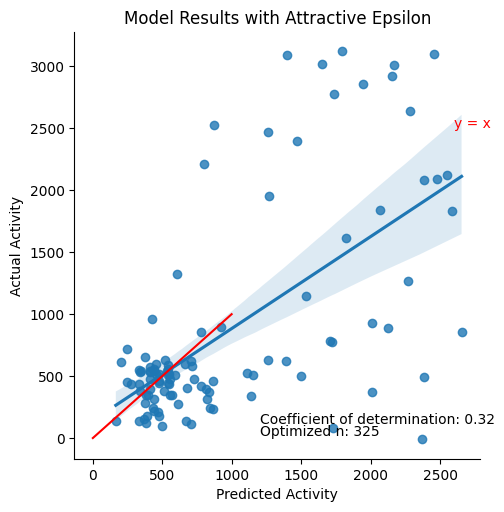

In [456]:
sns.lmplot(best_results, x = "Predicted Activity", y = "Actual Activity")
sns.lineplot(x = range(1000), y = range(1000), color="red")
plt.text(2600, 2500, "y = x", color="red")
plt.text(1200, 120, "Coefficient of determination: " + str(np.round(max_score, 2)))
plt.text(1200, 20, "Optimized n: " + str(best_k))
plt.title("Model Results with Attractive Epsilon")
plt.savefig("figures/staller5lib/regressionmodel_results_with_ADAD_attractive_epsilon.png", bbox_inches="tight")

In [ ]:
kbestfeatures = SelectKBest(f_regression, k=best_k)
bestfeatures = kbestfeatures.fit_transform(X, y)
bestfeatures_labels = kbestfeatures.get_feature_names_out()

best_model_df = pd.DataFrame(bestfeatures)
best_model_df.columns = bestfeatures_labels
best_model_df["Activity"] = y

---
## AD:DBD

In [424]:
AD_DBD = pd.read_csv("helperdata/manual CoAs/Staller5libADs_DBDs.csv").drop("Unnamed: 0", axis=1)
AD_DBD["Activity"] = AD_library["Activity_Mean_MSS18"] - 2000

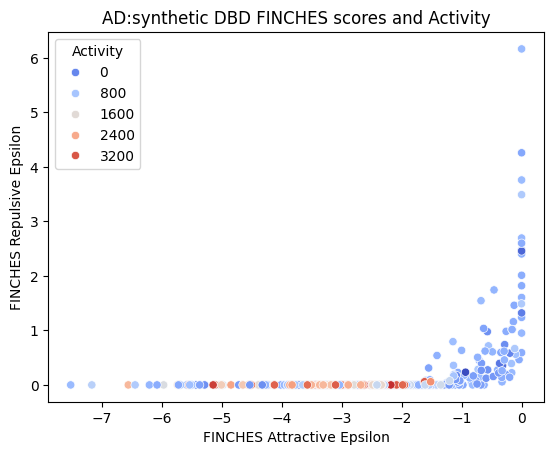

In [428]:
sns.scatterplot(AD_DBD.fillna(0), x = "Attractive e (mf)", y = "Repulsive e (mf)", hue="Activity", palette="coolwarm")
plt.xlabel("FINCHES Attractive Epsilon")
plt.ylabel("FINCHES Repulsive Epsilon")
plt.title("AD:synthetic DBD FINCHES scores and Activity")
plt.savefig("figures/staller5lib/ad_dbd_attractive_repulsive.png", bbox_inches="tight")

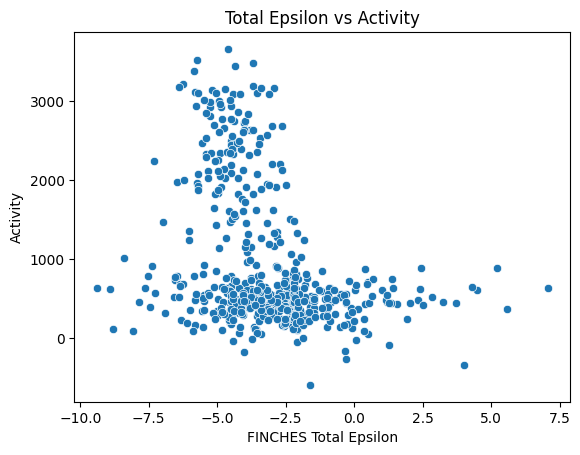

In [430]:
sns.scatterplot(AD_DBD, x = "Total e (mf)", y = "Activity") 
plt.xlabel("FINCHES Total Epsilon")
plt.title("Total Epsilon vs Activity")
plt.savefig("figures/staller5lib/ad_dbd_total.png", bbox_inches="tight")